## Flajolet-Martin

- ver1, ver2 구현 / 정확도 비교

100%|██████████████████████████████████████████████████████████████████████| 100000/100000 [00:00<00:00, 168671.79it/s]


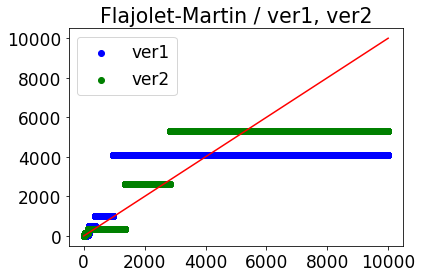

In [5]:
import math
import mmh3
import random

class FM_ver2:
    def __init__(self, domain_size):
        self.bitarray = 0 # 아이템이 들어올 때마다 업데이트할 비트배열
        self.domain_size = domain_size
        self.n_bits = math.ceil(math.log2(domain_size)) # 비트배열 N의 크기
        self.mask = (1 << self.n_bits) - 1 # 배열의 크기만큼 1을 가진 비트배열 생성
        self.seed = random.randint(0,999999)
    
    def put(self,item):
        h = mmh3.hash(item, self.seed) & self.mask # 두 숫자 모두 이진법으로 바꿔주고 똑같이 1에 해당하는 값만 취함
        r = 0
        
        if h == 0:return
        
        while h & (1 << r) == 0: r+= 1 # least significant set bit의 위치를 확인하면서 없으면 r 갱신
                                        # 2의 몇승이 LSB인지 확인하는 과정
        
        self.bitarray |= (1 << r) # |= -> AND연산 이후 할당 / bitarray 갱신
        
    def size(self):
        
        R = 0
        while(self.bitarray & (1 << R) != 0):R+=1
        
        return 2**R / 0.77351

class FM_ver1:
    def __init__(self, domain_size):
        self.R = 0 # 최대값을 저장하기 위한 변수
        self.domain_size = domain_size
        self.n_bits = math.ceil(math.log2(domain_size)) 
        self.mask = (1 << self.n_bits) - 1
        self.seed = random.randint(0,999999)
    
    def put(self,item):
        h = mmh3.hash(item, self.seed) & self.mask
        r = 0
        
        if h == 0:return # h가 0인 경우
        
        while h & (1 << r) == 0: r+= 1 # r을 갱신해줌
        
        if self.R < r: # 최대값을 확인하기 위해 R과 r을 비교
            self.R = r # 갱신
        
    def size(self): return 2**self.R


import matplotlib.pyplot as plt
from tqdm import tqdm

domain_size = 100000
fm_1 = FM_ver1(domain_size)
fm_2 = FM_ver2(domain_size)

tset = set() # 실제값

x = []
y_ver1 = []
y_ver2 = []

for i in tqdm(range(100000)):
    item = str(random.randint(0, 10000))
    fm_1.put(item)
    fm_2.put(item)
    tset.add(item)
    
    x.append(len(tset))
    y_ver1.append(fm_1.size())
    y_ver2.append(fm_2.size())

plt.scatter(x,y_ver1, color = 'b', label='ver1')
plt.scatter(x,y_ver2, color = 'g', label='ver2')
plt.plot(x,x, color = 'r')
plt.title('Flajolet-Martin / ver1, ver2')
plt.legend()
plt.savefig('./fm_v12.png')
plt.show()

- Version 2의 정확도 상승

In [6]:
# 리스트를 나누어주기 위한 함수
def list_chuck(arr, n):
    return [arr[i: i + n] for i in range(0, len(arr), n)]

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [02:42<00:00, 614.40it/s]


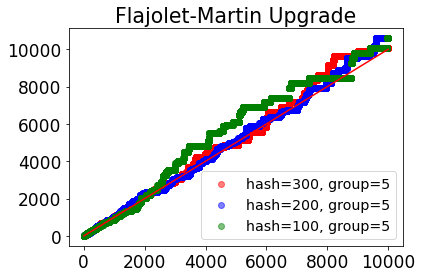

In [7]:
import math
import mmh3
import random
import statistics # 중앙값을 찾기 위함

class FM_ver2:
    def __init__(self, domain_size, n_hashs, n_groups):
        self.bitarray = [0] * n_hashs # 해쉬의 수만큼 생성후 갱신해주기 위함
        self.domain_size = domain_size
        self.n_bits = math.ceil(math.log2(domain_size)) # 비트배열 N의 크기
        self.mask = (1 << self.n_bits) - 1 # 배열의 크기만큼 1을 가진 비트배열 생성
        self.seeds = [random.randint(0,999999) for i in range(n_hashs)] # 해쉬의 수만큼 seed생성
        self.n_hashs = n_hashs # 해쉬의 수 조절
        self.n_groups = n_groups
        
    def put(self,item): # i에 따라 해쉬가 바뀌고 각자 저장됨
        for i in range(self.n_hashs): # hash의 수만큼 반복
            h = mmh3.hash(item, self.seeds[i]) & self.mask # 두 숫자 모두 이진법으로 바꿔주고 똑같이 1에 해당하는 값만 취함 / 각 해쉬에 맞는 seed설정
            r = 0

            if h == 0:return
            
            while h & (1 << r) == 0: r+= 1 # least significant set bit의 위치를 확인하면서 없으면 r 갱신
                                        # 2의 몇승이 LSB인지 확인하는 과정
            
            self.bitarray[i] |= (1 << r) # |= -> AND연산 이후 할당 / bitarray 갱신


    def size(self):
        R_list = []
        groups = list_chuck(self.bitarray, self.n_groups) # bitarray에 있는 값들을 지정한 그룹으로 나누어줌
        for group in groups:
            preds = []
            for barray in group: # 그룹 안의 수 비교
                R = 0
                while(barray & (1 << R) != 0):R+=1 # bitarray의 값 하나하나 비교
                
                preds.append(2**R / 0.77351) # 리스트에 추가
                
            R_list.append(statistics.median(preds)) # 중앙값 찾아줌
        return sum(R_list) / len(R_list) # 평균값 리턴

import matplotlib.pyplot as plt
from tqdm import tqdm

fm1 = FM_ver2(100000, 300, 15)
fm2 = FM_ver2(100000, 200, 10)
fm3 = FM_ver2(100000, 100, 5)

tset = set()


x = []
y1 = []
y2 = []
y3 = []

for i in tqdm(range(100000)):
    item = str(random.randint(0, 10000))
    fm1.put(item)
    fm2.put(item)
    fm3.put(item)
    tset.add(item)
    
    x.append(len(tset))
    y1.append(fm1.size())
    y2.append(fm2.size())
    y3.append(fm3.size())
    
plt.scatter(x,y1, c = 'r', alpha=0.5, label='hash=300, group=5')
plt.scatter(x,y2, c = 'b', alpha=0.5, label='hash=200, group=5')
plt.scatter(x,y3, c = 'g', alpha=0.5, label='hash=100, group=5')

plt.plot(x,x, color = 'r')
plt.title('Flajolet-Martin Upgrade')
# plt.savefig('./fm_up.png')
plt.legend(fontsize='small')
plt.show()

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [01:21<00:00, 1227.41it/s]


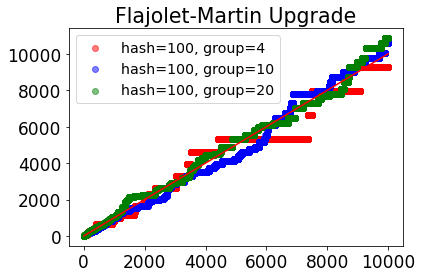

In [8]:
fm1 = FM_ver2(100000, 100, 25)
fm2 = FM_ver2(100000, 100, 10)
fm3 = FM_ver2(100000, 100, 5)

tset = set()


x = []
y1 = []
y2 = []
y3 = []

for i in tqdm(range(100000)):
    item = str(random.randint(0, 10000))
    fm1.put(item)
    fm2.put(item)
    fm3.put(item)
    tset.add(item)
    
    x.append(len(tset))
    y1.append(fm1.size())
    y2.append(fm2.size())
    y3.append(fm3.size())
    
plt.scatter(x,y1, c = 'r', alpha=0.5, label='hash=100, group=4')
plt.scatter(x,y2, c = 'b', alpha=0.5, label='hash=100, group=10')
plt.scatter(x,y3, c = 'g', alpha=0.5, label='hash=100, group=20')

plt.plot(x,x, color = 'r')
plt.title('Flajolet-Martin Upgrade')
# plt.savefig('./fm_up.png')
plt.legend(fontsize='small')
plt.show()